In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import folium
import plotly.express as px
import nbformat
import random
from scipy.optimize import curve_fit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel("./data/Pittsburgh_AMS_Mobile_2016_2017.xlsx")

In [13]:
df_NO2 = df.dropna(subset=['NO2'])

In [15]:
# 13K
df_NO2.shape

(13377, 47)

In [16]:
df_NO2["date"] = df_NO2["datetime"].dt.date
df_NO2["time"] = df_NO2["datetime"].dt.time
df_NO2["year"] = df_NO2["datetime"].dt.year
df_NO2["day"] = df_NO2["datetime"].dt.day

/var/folders/jb/d50lm02n7cz_c9129ll301m40000gn/T/ipykernel_307/4185981233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NO2["date"] = df_NO2["datetime"].dt.date
/var/folders/jb/d50lm02n7cz_c9129ll301m40000gn/T/ipykernel_307/4185981233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NO2["time"] = df_NO2["datetime"].dt.time
/var/folders/jb/d50lm02n7cz_c9129ll301m40000gn/T/ipykernel_307/4185981233.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [17]:
df_NO2["time"].sort_values(ascending=False)

15413    23:21:43
15412    23:21:22
15411    23:21:01
15410    23:20:40
15409    23:20:19
           ...   
470      03:11:00
469      03:10:01
63       03:10:00
62       03:09:01
61       03:07:59
Name: time, Length: 13377, dtype: object

In [18]:
df_NO2['datetime'].head()

0   2016-08-08 09:55:00
1   2016-08-08 09:56:02
2   2016-08-08 09:56:59
3   2016-08-08 09:58:01
4   2016-08-08 09:59:00
Name: datetime, dtype: datetime64[ns]

##  Data Overview

In [1188]:
# df_testtrain = df_NO2[(df_NO2["day"] <= 14) | (df_NO2["month"] != 2)]

32 different days span from summer, fall, winter; all on week-day

In [8]:
df_NO2.groupby(["year", "month", "day"]).size()

year  month  day
2016  8      8        61
             9       111
             11      287
             12      286
             15      313
             17       86
      9      13      147
             15      298
             20      303
             22      133
             23       85
             26      288
      11     16      615
             18      740
             21      687
             22      682
2017  1      25     1070
             26      320
             27      324
             30      119
             31      831
      2      1       414
             2       897
             3       488
             6       270
             7       631
             8       171
             13      526
             14      662
             15      235
             16      697
             17      600
dtype: int64

In [10]:
df_NO2 = df_NO2 #df_NO2[['datetime','NO2']]

In [19]:
df_NO2.head()

,OBJECTID,datetime,run_index,Longitude,Latitude,Elevation,hour,CO2,CO,NO,...,BCLocal,weight,site,period,season,type,date,time,year,day
0,1,2016-08-08 09:55:00,21648,-79.962249,40.441570,293.650820,9,535.973841,0.390839,19.375092,...,0.666689,3,0,1,1,3,2016-08-08,09:55:00,2016,8
1,2,2016-08-08 09:56:02,21649,-79.965543,40.443281,342.895238,9,524.337810,0.390429,15.009414,...,0.337680,3,9,1,1,3,2016-08-08,09:56:02,2016,8
2,3,2016-08-08 09:56:59,21650,-79.965617,40.445433,366.213793,9,520.587519,0.391188,19.160648,...,0.426720,3,9,1,1,3,2016-08-08,09:56:59,2016,8
3,4,2016-08-08 09:58:01,21651,-79.965430,40.446530,368.885714,9,515.956838,0.390167,11.922513,...,0.285965,3,9,1,1,3,2016-08-08,09:58:01,2016,8
4,5,2016-08-08 09:59:00,21652,-79.965450,40.446502,369.160000,9,512.491392,0.388597,10.575528,...,0.526177,3,9,1,1,3,2016-08-08,09:59:00,2016,8


# Preprocessing (negative, outlier, time interval)

remove negative value

In [20]:
df_NO2 = df_NO2[df_NO2['NO2']>0]

remove outlier that is outside 3 std dev from the mean

In [21]:
mean = df_NO2['NO2'].mean()
std_dev =df_NO2['NO2'].std()

In [22]:
print('l:', mean-3 * std_dev ,'h',mean+ 3 * std_dev)

l: -16.621030051248344 h 40.832591757488515


In [23]:
filtered_df = df_NO2[(df_NO2['NO2'] >= mean - 3 * std_dev) & (df_NO2['NO2'] <= mean + 3 * std_dev)]

In [24]:
# remove 123 outlier 
len(df_NO2)- len(filtered_df)

121

In [1389]:
df_NO2 = filtered_df

Time interval transformation (hour)

In [25]:
df_NO2['tot_hour_numeric'] = (df_NO2['datetime'] - df_NO2['datetime'].min()).dt.total_seconds()/3600.0

In [26]:
df_NO2['tot_hour_numeric'].head()

0    0.000000
1    0.017222
2    0.033056
3    0.050278
4    0.066667
Name: tot_hour_numeric, dtype: float64

Time interval in minutes

In [27]:
df_NO2['tot_min_numeric'] = (df_NO2['datetime'] - df_NO2['datetime'].min()).dt.total_seconds()/60

In [28]:
df_NO2['tot_min_numeric'].head()

0    0.000000
1    1.033333
2    1.983333
3    3.016667
4    4.000000
Name: tot_min_numeric, dtype: float64

Round to nearest minute and see if there are any time points at which we have more than one observation

In [29]:
df_NO2['tot_min_rounded'] = np.round(df_NO2['tot_min_numeric'], decimals = 0)

In [31]:
# Grouping by 'tot_min_rounded' and counting occurrences
grouped = df_NO2.groupby('tot_min_rounded').size().reset_index(name='count')
duplicates = grouped[grouped['count'] > 1]
print(duplicates)

      tot_min_rounded  count
1777         144191.0      2
1778         144192.0      3
1780         144194.0      2
1781         144195.0      2
1782         144196.0      2
...               ...    ...
5607         278173.0      3
5608         278174.0      3
5609         278175.0      3
5610         278176.0      3
5611         278177.0      2

[3655 rows x 2 columns]


# Data Split

Two splits: observation prediction split

In [32]:
observation_set, validation_set = train_test_split(df_NO2, test_size=0.2, random_state=42)

In [33]:
len(observation_set)+len(validation_set)

11833

After train-test split, sort the dataset by datetime

In [1396]:
observation_set= observation_set.sort_values(by ='datetime_numeric' ,ascending = True)
validation_set= validation_set.sort_values(by ='datetime_numeric' ,ascending = True)

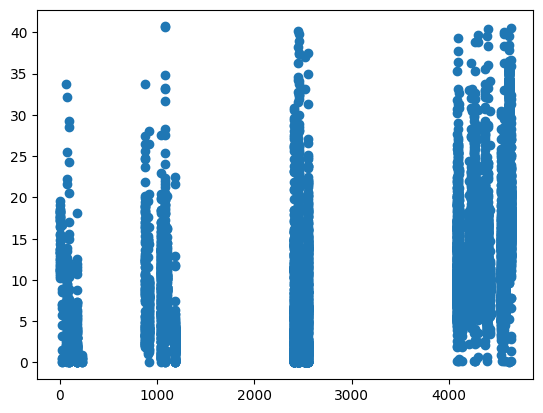

In [1397]:
plt.scatter(observation_set['datetime_numeric'],observation_set['NO2'])

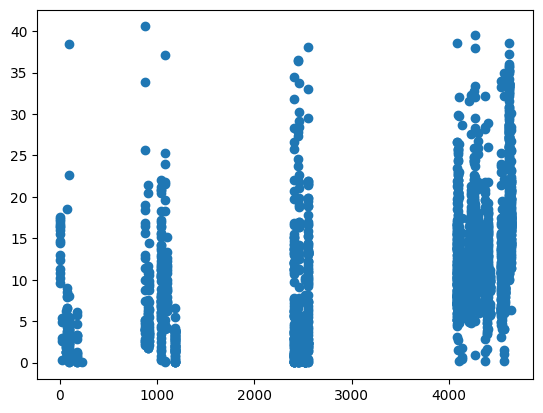

In [1398]:
plt.scatter(validation_set['datetime_numeric'],validation_set['NO2'])

In [1399]:
observation_set['datetime_numeric'].nunique()

9369

In [1400]:
len(observation_set)

9369

Save the training and validation sets as .csv files

In [34]:
observation_set.to_csv('observation_set.csv', index=False)

In [35]:
validation_set.to_csv('validation_set.csv', index = False)

# Model fitting (without turn on normalize_y)

fit the model using observation set

In [1212]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# periodicity_bounds="fixed"
# length_scale_bounds="fixed"

## RBF kernel (best parameter:'length_scale': 0.1, 'alpha': 10.0）

In [1401]:
X_train, X_test, y_train, y_test = observation_set['datetime_numeric'], validation_set['datetime_numeric'], observation_set['NO2'],validation_set['NO2']

In [1402]:
# Define the parameter grid manually
length_scale_range = np.logspace(-2, 2, 5)
alpha_range = np.logspace(-10, 1, 5)

# Keep track of the best score and corresponding parameters
best_log_likelihood = -np.inf
best_params = {}

# Manually iterate over the parameter grid
for i,length_scale in enumerate(length_scale_range):
    for j,alpha in enumerate(alpha_range):
        # Define the kernel with current parameters
        kernel = C(1.0) * RBF(length_scale=length_scale,length_scale_bounds="fixed")
        # Instantiate the Gaussian Process Regressor with the kernel and alpha
        gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=42)
        
        # Fit the model on the training set
        gp.fit(X_train.values.reshape(-1,1), y_train)
        
        log_likelihood = gp.log_marginal_likelihood_value_
        score = gp.score(X_train.values.reshape(-1,1), y_train)
        
        print(f'>>>>length: {length_scale},alpha: {alpha}, training r2 score:',score)
        
        # If the score of the current model is better than the best score so far,
        # update the best score and best parameters
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_params = {'length_scale': length_scale, 'alpha': alpha}

# Print the best parameters
print("Best parameters:", best_params)
print("Best log likelihood:", best_log_likelihood)

>>>>length: 0.01,alpha: 1e-10, training r2 score: 1.0
>>>>length: 0.01,alpha: 5.6234132519034905e-08, training r2 score: 0.9999999999999987
>>>>length: 0.01,alpha: 3.1622776601683795e-05, training r2 score: 0.9999999995759316
>>>>length: 0.01,alpha: 0.01778279410038923, training r2 score: 0.9998659922837774
>>>>length: 0.01,alpha: 10.0, training r2 score: 0.9753301521402745
>>>>length: 0.1,alpha: 1e-10, training r2 score: 0.8753101901580256


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 0.1,alpha: 5.6234132519034905e-08, training r2 score: 0.8827501552856806


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 0.1,alpha: 3.1622776601683795e-05, training r2 score: 0.8735338033568365


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 0.1,alpha: 0.01778279410038923, training r2 score: 0.8606198294687233
>>>>length: 0.1,alpha: 10.0, training r2 score: 0.8066540084020203
>>>>length: 1.0,alpha: 1e-10, training r2 score: 0.7406822246051163


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 1.0,alpha: 5.6234132519034905e-08, training r2 score: 0.7458029744550609


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 1.0,alpha: 3.1622776601683795e-05, training r2 score: 0.7386782340386124


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 1.0,alpha: 0.01778279410038923, training r2 score: 0.7271633098924244
>>>>length: 1.0,alpha: 10.0, training r2 score: 0.7060637488300863
>>>>length: 10.0,alpha: 1e-10, training r2 score: 0.6348510094381008


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 10.0,alpha: 5.6234132519034905e-08, training r2 score: 0.6501551853954712


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 10.0,alpha: 3.1622776601683795e-05, training r2 score: 0.6320763451330752


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 10.0,alpha: 0.01778279410038923, training r2 score: 0.6165192910067314


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 10.0,alpha: 10.0, training r2 score: 0.6051233846455308
>>>>length: 100.0,alpha: 1e-10, training r2 score: 0.49200608041980554


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 100.0,alpha: 5.6234132519034905e-08, training r2 score: 0.5073182154210161


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 100.0,alpha: 3.1622776601683795e-05, training r2 score: 0.4883509926762989


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 100.0,alpha: 0.01778279410038923, training r2 score: 0.47864591074080254


/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


>>>>length: 100.0,alpha: 10.0, training r2 score: 0.45215421649644927
Best parameters: {'length_scale': 0.1, 'alpha': 10.0}
Best log likelihood: -26892.619470962294


Use the optimal parameter to refit the model

In [1403]:
kernel = C(1.0) * RBF(length_scale=0.1,length_scale_bounds="fixed")
# Instantiate the Gaussian Process Regressor with the kernel and alpha
gp = GaussianProcessRegressor(kernel=kernel, alpha=10, random_state=42)

# Fit the model on the observation set
gp.fit(X_train.values.reshape(-1,1), y_train)

# Evaluate the model on the validation set
score = gp.score(X_test.values.reshape(-1,1), y_test)

In [1404]:
y_mean, y_std = gp.predict(observation_set['datetime_numeric'].values.reshape(-1,1),return_std=True)

Observation fitting plot

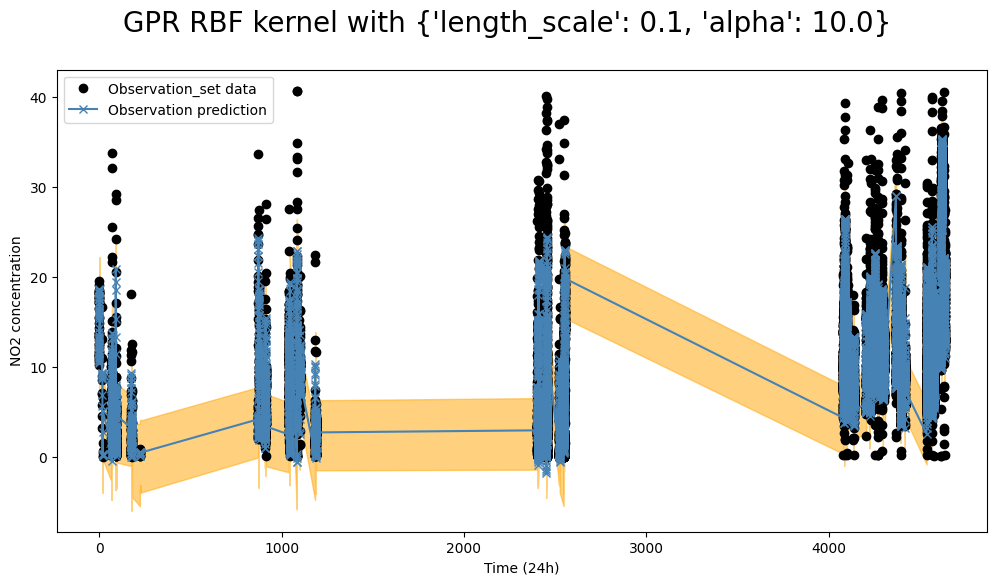

In [1406]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(observation_set['datetime_numeric'], observation_set['NO2'], color='black', marker='o',label="Observation_set data",linewidth=0) # 
# plt.scatter(agg_train['24time'], agg_train['NO2'], color="red", label="Training data")
plt.plot(observation_set['datetime_numeric'], y_mean, marker='x', color='steelblue',label="Observation prediction")
plt.fill_between(observation_set['datetime_numeric'], y_mean - 2 * y_std, y_mean + 2 * y_std[1],color='orange', alpha=0.5)
plt.xlabel("Time (24h)")
plt.ylabel("NO2 concentration") # Set y-axis label
plt.suptitle(f"GPR RBF kernel with {best_params}", fontsize=20)
plt.legend() 

In [1413]:
# training performance
mse = mean_squared_error(y_mean, observation_set['NO2'])
print(f'Training mse: {mse}')
print(f'Training r2: {score}')
score

Training mse: 10.584103210196162
Training r2: 0.7388401460917386


0.7388401460917386

In [1412]:
# validation performance
y_mean_val, y_std_val = gp.predict(validation_set['datetime_numeric'].values.reshape(-1,1),return_std=True)
mse2 = mean_squared_error(y_mean_val, validation_set['NO2'])
r22 = r2_score(y_mean_val, validation_set['NO2'])
print(f'Validation mse: {mse2}')
print(f'Validation r2: {r22 }')

Validation mse: 13.991228164773837
Validation r2: 0.6490774475323333


Validation fitting plot

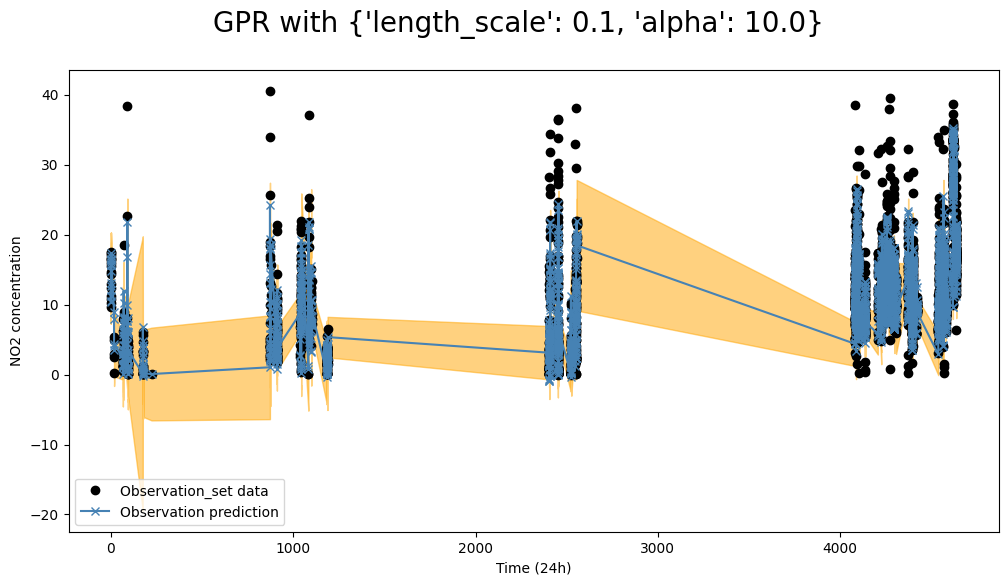

In [1418]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(validation_set['datetime_numeric'], validation_set['NO2'], color='black', marker='o',label="Observation_set data",linewidth=0) # 
# plt.scatter(agg_train['24time'], agg_train['NO2'], color="red", label="Training data")
plt.plot(validation_set['datetime_numeric'], y_mean_val, marker='x', color='steelblue',label="Observation prediction")
plt.fill_between(validation_set['datetime_numeric'], y_mean_val - 2 * y_std_val, y_mean_val + 2 * y_std_val,color='orange', alpha=0.5)
plt.xlabel("Time (24h)")
plt.ylabel("NO2 concentration") # Set y-axis label
plt.suptitle(f"GPR with {best_params}", fontsize=20)
plt.legend() 

## Expsinsquare kernel; 'length_scale': 0.0001291549665014884, 'periodicity': 7742.636826811277, 'alpha': 0.5

In [1419]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel

# Example data (replace with your observation_set)
# observation_set = ...

# Define ranges for hyperparameters
length_scale_range = np.logspace(-5, 5, 10)
periodicity_range = np.logspace(-5, 5, 10)
alpha_range = np.linspace(0.1, 0.5, 5)  # Noise level

best_log_likelihood = -np.inf
best_params = {}

# Iterate over all combinations of hyperparameters
for length_scale in length_scale_range:
    for periodicity in periodicity_range:
        for alpha in alpha_range:
            kernel = ExpSineSquared(length_scale=length_scale, periodicity=periodicity, length_scale_bounds= 'fixed', periodicity_bounds = 'fixed') + WhiteKernel(noise_level=alpha, noise_level_bounds = 'fixed')
            gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=42)

            # Fit the model
            gp.fit(observation_set['datetime_numeric'].values.reshape(-1, 1), observation_set['NO2'])

            # Calculate log likelihood
            log_likelihood = gp.log_marginal_likelihood_value_
            # calculate r2 
            score = gp.score(X_test.values.reshape(-1,1), y_test)
            print(f'>>>>length: {length_scale},periodicity: {periodicity}, alpha: {alpha}, score:',score)

            # Check if this is the best log likelihood so far
            if log_likelihood > best_log_likelihood:
                best_log_likelihood = log_likelihood
                best_params = {'length_scale': length_scale, 'periodicity': periodicity, 'alpha': alpha}

# Print the best parameters and corresponding log likelihood
print("Best parameters:", best_params)
print("Best log likelihood:", best_log_likelihood)


KeyboardInterrupt: 

In [1310]:
# performance on observation 
kernel = ExpSineSquared(length_scale= 0.0001291549665014884, periodicity = 7742.636826811277, length_scale_bounds= 'fixed', periodicity_bounds = 'fixed') + WhiteKernel(noise_level=0.5, noise_level_bounds = 'fixed')
gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=42)

# Fit the model
gp.fit(observation_set['datetime_numeric'].values.reshape(-1, 1), observation_set['NO2'])

# Calculate log likelihood
log_likelihood = gp.log_marginal_likelihood_value_
# calculate r2 
score1 = gp.score(X_train.values.reshape(-1,1), y_train)

In [1311]:
# r2 on observation
score1 

0.6750796636152365

In [1312]:
# r2 on validation
score2 = gp.score(X_test.values.reshape(-1,1), y_test)
score2

0.5914667708607659

training fitting plot

In [1330]:
len(y_pred[0])

8142

In [1333]:
train_dates = pd.date_range(start='2016-08-08', end='2017-02-05', freq='D')

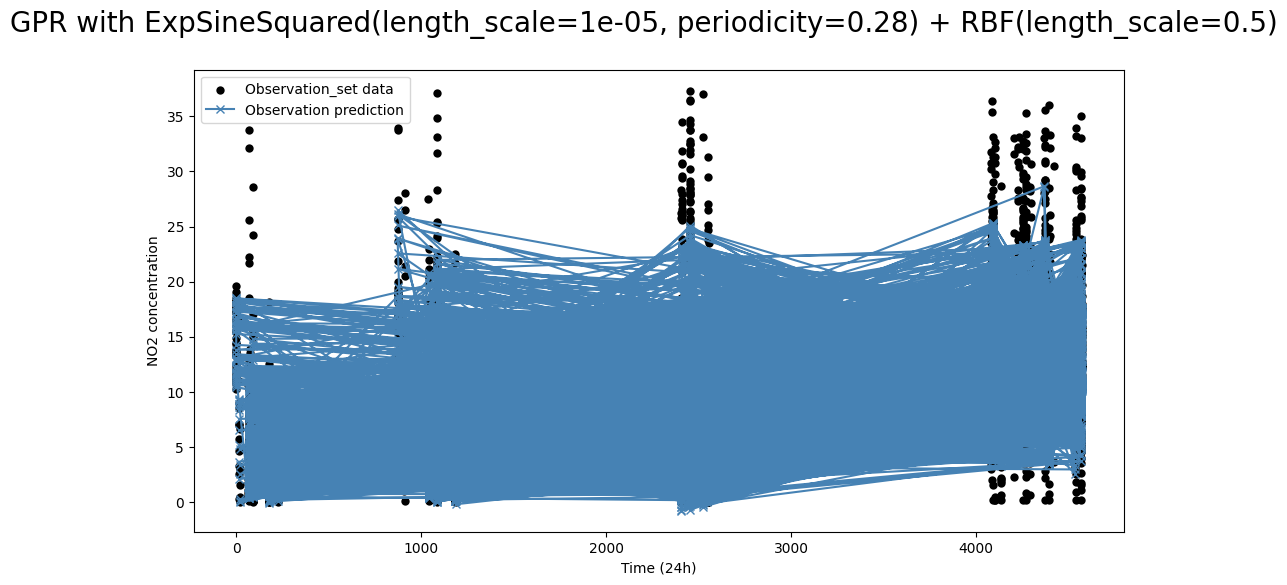

In [1327]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.scatter(observation_set['datetime_numeric'], observation_set['NO2'], color='black', marker='o',label="Observation_set data",linewidth=0) # 
# plt.scatter(agg_train['24time'], agg_train['NO2'], color="red", label="Training data")
plt.plot(observation_set['datetime_numeric'], y_pred[0], marker='x', color='steelblue',label="Observation prediction")
#plt.fill_between(observation_set['datetime_numeric'], y_pred[0] - 2 * y_pred[1], y_pred[0] + 2 * y_pred[1],color='orange', alpha=0.5)
plt.xlabel("Time (24h)")
plt.ylabel("NO2 concentration") # Set y-axis label
plt.suptitle(f"GPR with {clf.kernel_}", fontsize=20)
plt.legend() 

validation fitting plot

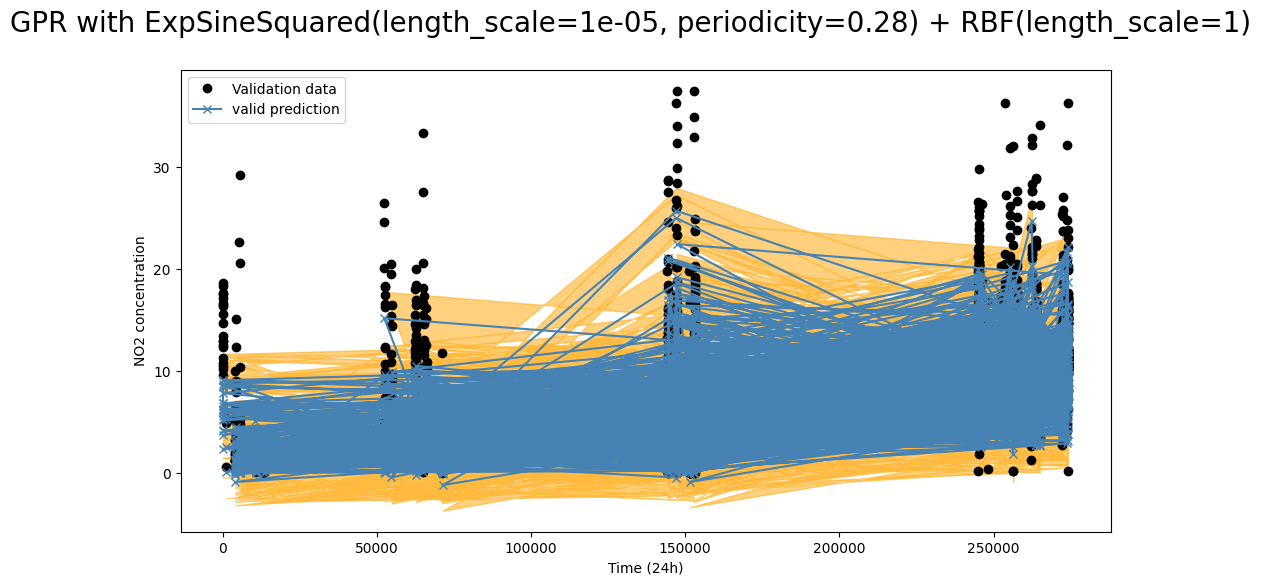

In [1102]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(validation_set['datetime_numeric'], validation_set['NO2'], color='black', marker='o',label="Validation data",linewidth=0) # 
# plt.scatter(agg_train['24time'], agg_train['NO2'], color="red", label="Training data")
plt.plot(validation_set['datetime_numeric'], y_pred_valid[0], marker='x', color='steelblue',label="valid prediction")
plt.fill_between(validation_set['datetime_numeric'], y_pred_valid[0] - 2 * y_pred_valid[1], y_pred_valid[0] + 2 * y_pred_valid[1],color='orange', alpha=0.5)
plt.xlabel("Time (24h)")
plt.ylabel("NO2 concentration") # Set y-axis label
plt.suptitle(f"GPR with {clf.kernel_}", fontsize=20)
plt.legend() 

# Model fitting (turn on normalize_y)

In [1422]:
# Fix me: more trails